In [1]:
# Example usage of different interpretability techniques.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import json

from interpretability_methods.vanilla_gradients import VanillaGradients
from interpretability_methods.integrated_gradients import IntegratedGradients
from interpretability_methods.guided_backprop import GuidedBackprop
from interpretability_methods.input_x_gradient import InputXGradient
from interpretability_methods.gradcam import GradCAM
from interpretability_methods.guided_gradcam import GuidedGradCAM
from interpretability_methods.kernel_shap import KernelSHAP
from interpretability_methods.gradient_shap import GradientSHAP
from interpretability_methods.xrai import XRAI
from interpretability_methods.rise import RISE
from interpretability_methods.lime import LIME

from interpretability_methods.util import visualize_masks

## Load Model and Example Image

In [4]:
# Load Inception V3 Model
def load_model_from_pytorch(architecture, pretrained=True):
    model = models.__dict__[architecture](pretrained=pretrained)
    return model 
MODEL = load_model_from_pytorch('inception_v3', pretrained=True).cuda().eval()

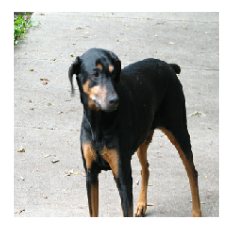

In [5]:
# Load Test Image
def load_image(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    return im / 127.5 - 1.0 # normalize -1 to 1 for inception

def show_image(im, ax=None):
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1)
    ax.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    ax.imshow(im)
    
def show_batch(batch):
    batch_size = batch.shape[0]
    fig, axes = plt.subplots(nrows=1, ncols=batch_size)
    for i, image in enumerate(batch):
        show_image(image, axes[i])
    
IMAGE = load_image('./doberman.png')
show_image(IMAGE)

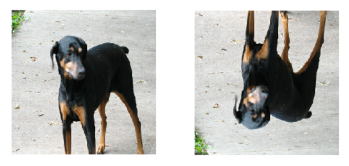

In [6]:
# Make Test Image Batch
input_instance = torch.from_numpy(IMAGE.transpose(2, 0, 1)).cuda().float()[:3, :, :]
input_instance_flipped = torch.from_numpy(np.flip(IMAGE.transpose(2, 0, 1), axis=1).copy()).cuda().float()[:3, :, :]
input_batch = torch.stack([input_instance, input_instance_flipped])
show_batch(input_batch.detach().cpu().numpy().transpose(0, 2, 3, 1))

In [7]:
# Predict Image Class
with open('/home/aboggust/data/imagenet/labels.json', 'r') as f:
    labels = json.load(f)
output = MODEL(input_batch)
predictions = np.argmax(output.cpu().detach().numpy(), axis=1)
for i, prediction in enumerate(predictions):
    print('Prediction %d:' %i, prediction, labels[prediction])

Prediction 0: 236 ['n02107142', 'Doberman', '236']
Prediction 1: 236 ['n02107142', 'Doberman', '236']


## Vanilla Gradients

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


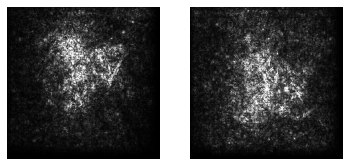

In [8]:
vanilla_gradients = VanillaGradients(MODEL)
vanilla_gradient_masks = vanilla_gradients.get_masks(input_batch)
visualize_masks(vanilla_gradient_masks)

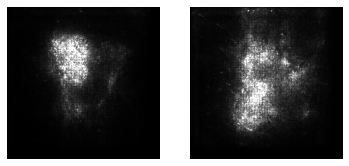

In [9]:
vanilla_gradient_smoothgrad_masks = vanilla_gradients.get_smoothgrad_masks(input_batch)
visualize_masks(vanilla_gradient_smoothgrad_masks)

## Integrated Gradients

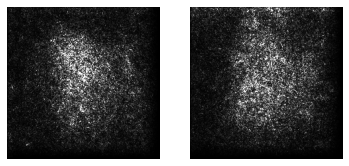

In [10]:
integrated_gradients = IntegratedGradients(MODEL)
integrated_gradient_masks = integrated_gradients.get_masks(input_batch)
visualize_masks(integrated_gradient_masks)

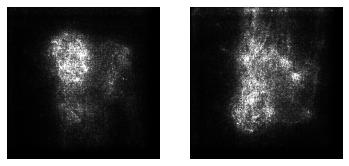

In [11]:
integrated_gradient_smoothgrad_masks = integrated_gradients.get_smoothgrad_masks(input_batch)
visualize_masks(integrated_gradient_smoothgrad_masks)

## Guided BackProp

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


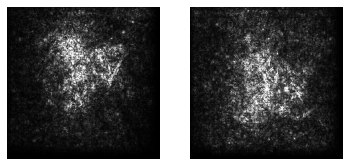

In [12]:
guided_backprop = GuidedBackprop(MODEL)
guided_backprop_masks = guided_backprop.get_masks(input_batch)
visualize_masks(guided_backprop_masks)

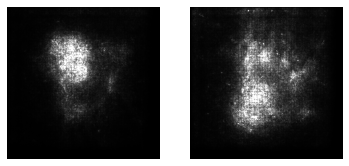

In [13]:
guided_backprop_smoothgrad_masks = guided_backprop.get_smoothgrad_masks(input_batch)
visualize_masks(guided_backprop_smoothgrad_masks)

## Input X Gradient

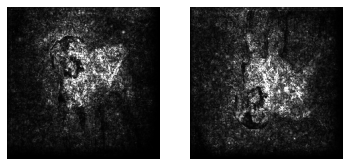

In [14]:
input_x_gradient = InputXGradient(MODEL)
input_x_gradient_masks = input_x_gradient.get_masks(input_batch)
visualize_masks(input_x_gradient_masks)

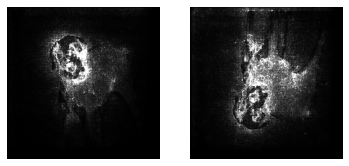

In [15]:
input_x_gradient_smoothgrad_masks = input_x_gradient.get_smoothgrad_masks(input_batch)
visualize_masks(input_x_gradient_smoothgrad_masks)

## GradCAM

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


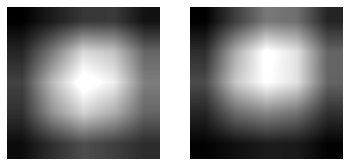

In [16]:
gradcam = GradCAM(MODEL, MODEL.Mixed_7c)
gradcam_masks = gradcam.get_masks(input_batch)
visualize_masks(gradcam_masks)

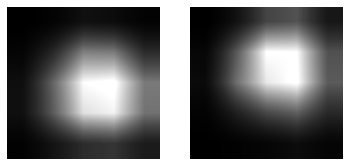

In [17]:
gradcam_smoothgrad_masks = gradcam.get_smoothgrad_masks(input_batch)
visualize_masks(gradcam_smoothgrad_masks)

## Guided GradCAM

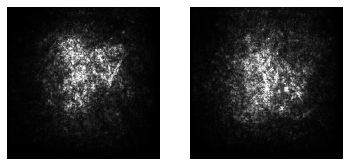

In [18]:
guided_gradcam = GuidedGradCAM(MODEL, MODEL.Mixed_7c)
guided_gradcam_masks = guided_gradcam.get_masks(input_batch)
visualize_masks(guided_gradcam_masks)

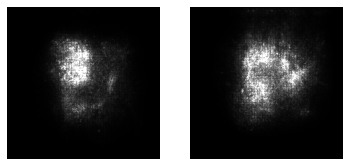

In [19]:
guided_gradcam_smoothgrad_masks = guided_gradcam.get_smoothgrad_masks(input_batch)
visualize_masks(guided_gradcam_smoothgrad_masks)

## Gradient SHAP

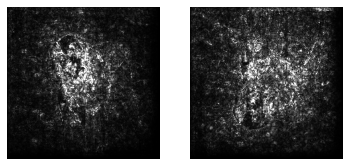

In [20]:
gradient_shap = GradientSHAP(MODEL)
gradient_shap_masks = gradient_shap.get_masks(input_batch)
visualize_masks(gradient_shap_masks)

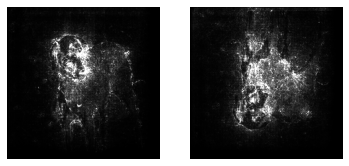

In [21]:
gradient_shap_smoothgrad_masks = gradient_shap.get_smoothgrad_masks(input_batch)
visualize_masks(gradient_shap_smoothgrad_masks)

## XRAI

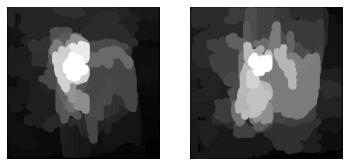

In [22]:
xrai = XRAI(MODEL)
xrai_masks = xrai.get_masks(input_batch)
visualize_masks(xrai_masks)

## LIME

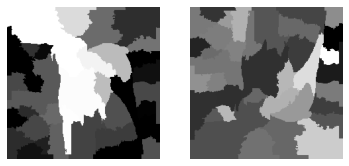

In [23]:
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

to_image = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    transforms.ToPILImage(),
])

lime = LIME(MODEL, to_image, to_tensor)
lime_masks = lime.get_masks(input_batch)
visualize_masks(lime_masks)